## Analiza modeli maszynowego uczenia się, na podstawie zbioru danych.



Na podstawie zbioru porównane zostaną różne modele uczenia maszynowego, będą to m.in. regresja liniowa, drzewo 
decyzyjne. W pracy zawarte zostanie optymalizacja danych, czyszczenie danych, optymalizacja modeli, ich szkolenie oraz końcowe porównanie.


### Spis treści z odnośnikami


<a class="anchor" id="0"></a>

1. [Import bibliotek](#1)
1. [Import danych](#2)
1. [Oczyszczenie danych](#2.1)
1. [Wstępna analiza zbioru](#3)
1. [Przygotowanie do uczenia](#4)
1. [Modele uczenia](#5)
    -  [Regresja liniowa](#5.1)
    -  [SVM](#5.2)
    -  [Liniowy SVR](#5.3)
    -  [MLPRegressor](#5.4)
    -  [Stochastic Gradient Descent](#5.5)
    -  [Decision Tree Regressor](#5.6)
    -  [Random Forest with GridSearchCV](#5.7)
    -  [XGB](#5.8)
    -  [LGBM](#5.9)
    -  [GradientBoostingRegressor with HyperOpt](#5.10)
    -  [RidgeRegressor](#5.11)
    -  [BaggingRegressor](#5.12)
    -  [ExtraTreesRegressor](#5.13)
    -  [AdaBoost Regressor](#5.14)
    -  [VotingRegressor](#5.15)
1. [Porównanie modeli](#6)
1. [Przewidywania](#7)

### 1. Import bibliotek <a class="anchor" id="1"></a>

[Powrót do spisu treści](#0)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import ydata_profiling as pp

# Modele
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Optymalizacja modeli
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

### 2. Import danych <a class="anchor" id="2"></a>

[Powrót do spisu treści](#0)

In [67]:
valid_part = 0.3
train0 = pd.read_csv('craigslistVehicles.csv')
train0.head(5)

url              city  \
0  https://grandrapids.craigslist.org/cto/d/hasti...  grand rapids, MI   
1  https://grandrapids.craigslist.org/cto/d/grand...  grand rapids, MI   
2  https://grandrapids.craigslist.org/ctd/d/chesa...  grand rapids, MI   
3  https://grandrapids.craigslist.org/ctd/d/chesa...  grand rapids, MI   
4  https://grandrapids.craigslist.org/ctd/d/caled...  grand rapids, MI   

                             city_url  price    year manufacturer  \
0  https://grandrapids.craigslist.org   1500  2006.0     cadillac   
1  https://grandrapids.craigslist.org   8900  2009.0      lincoln   
2  https://grandrapids.craigslist.org   7995  2010.0     cadillac   
3  https://grandrapids.craigslist.org   6995  2007.0          NaN   
4  https://grandrapids.craigslist.org  20990  2010.0          ram   

                     make  condition    cylinders    fuel  ...  transmission  \
0                     cts       good  6 cylinders     gas  ...     automatic   
1                     mkx        NaN          NaN     gas  ...     automatic   
2  srx premium collection        NaN          NaN     gas  ...     automatic   
3   hummer h3 4dr 4wd suv        NaN          NaN     gas  ...     automatic   
4                    2500  excellent  6 cylinders  diesel  ...     automatic   

                 VIN drive      size   type paint_color  \
0                NaN   rwd  mid-size  coupe        blue   
1                NaN   NaN       NaN    NaN         NaN   
2  3GYFNCEYXAS552363   NaN       NaN    NaN         NaN   
3  5GTDN13E478107380   NaN       NaN    NaN         NaN   
4  3D7UT2CL4AG113236   4wd       NaN    NaN       white   

                                           image_url  \
0  https://images.craigslist.org/00K0K_a9CZoZg2U8...   
1  https://images.craigslist.org/00a0a_9B4kPBDIWd...   
2  https://images.craigslist.org/00X0X_8i0VRuk7Cv...   
3  https://images.craigslist.org/00b0b_ahkmUzr4cE...   
4  https://images.craigslist.org/00505_3DHY0kFrgb...   

                                                desc        lat       long  
0    2006 CtS Leather, Runs and drives Good.236k mil  42.643000 -85.293700  
1  Selling our loaded 2009 Lincoln MKX with 119,0...  42.973700 -85.726500  
2  WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...  43.186723 -84.163862  
3  WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...  43.186723 -84.163862  
4  Great looking 2010 Ram 2500 ST w/6.7L 24V I6 4...  42.783714 -85.506777  

[5 rows x 22 columns]

### 3. Oczyszczenie danych <a class="anchor" id="2.1"></a>

[Powrót do spisu treści](#0)

In [68]:
drop_columns = ['url', 'city', 'city_url', 'make', 'title_status', 'VIN', 'size', 'image_url', 'desc', 'lat','long']
train0 = train0.drop(columns = drop_columns)
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525839 entries, 0 to 525838
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         525839 non-null  int64  
 1   year          524399 non-null  float64
 2   manufacturer  501260 non-null  object 
 3   condition     279881 non-null  object 
 4   cylinders     315439 non-null  object 
 5   fuel          521544 non-null  object 
 6   odometer      427248 non-null  float64
 7   transmission  521572 non-null  object 
 8   drive         374475 non-null  object 
 9   type          376906 non-null  object 
 10  paint_color   354306 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 44.1+ MB


In [69]:
train0 = train0.dropna()
train0.head(5)

price    year manufacturer  condition    cylinders fuel  odometer  \
0   1500  2006.0     cadillac       good  6 cylinders  gas  236000.0   
5   4950  2010.0       subaru       good  4 cylinders  gas  253000.0   
6   6850  2007.0          gmc       good  8 cylinders  gas  254000.0   
7   7995  2007.0        lexus  excellent  6 cylinders  gas  146111.0   
8   4995  2011.0      hyundai  excellent  4 cylinders  gas  115048.0   

  transmission drive   type paint_color  
0    automatic   rwd  coupe        blue  
5    automatic   4wd  sedan       white  
6    automatic   4wd  wagon       black  
7    automatic   fwd  sedan       white  
8    automatic   fwd  sedan        blue

In [70]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)

for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))

In [71]:
train0['year'] = (train0['year']-1900).astype(int)
train0['odometer'] = train0['odometer'].astype(int)
train0.head(10)

price  year  manufacturer  condition  cylinders  fuel  odometer  \
0    1500   106             6          2          5     2    236000   
5    4950   110            36          2          3     2    253000   
6    6850   107            14          2          6     2    254000   
7    7995   107            23          0          5     2    146111   
8    4995   111            17          0          3     2    115048   
9   12995   113            37          0          3     2     72936   
12   8000   110             3          2          5     2    150000   
18   6995   111             7          0          5     2    102000   
21  39000   117             7          0          6     2     43300   
24   8900   112            33          2          6     2    112000   

    transmission  drive  type  paint_color  
0              0      2     3            1  
5              0      0     9           10  
6              0      0    12            0  
7              0      1     9           10  
8              0      1     9            1  
9              0      1     4           10  
12             0      0     9            5  
18             0      1     9            1  
21             0      2     9            5  
24             0      2     8           10

In [72]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144903 entries, 0 to 525836
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   price         144903 non-null  int64
 1   year          144903 non-null  int32
 2   manufacturer  144903 non-null  int32
 3   condition     144903 non-null  int32
 4   cylinders     144903 non-null  int32
 5   fuel          144903 non-null  int32
 6   odometer      144903 non-null  int32
 7   transmission  144903 non-null  int32
 8   drive         144903 non-null  int32
 9   type          144903 non-null  int32
 10  paint_color   144903 non-null  int32
dtypes: int32(10), int64(1)
memory usage: 7.7 MB


### 4. Wstępna analiza danych<a class="anchor" id="3"></a>

[Back to Table of Contents](#0)

In [73]:
train0['price'].value_counts()

price
0        6755
1        1743
4500     1603
3500     1593
2500     1528
         ... 
12761       1
5445        1
25470       1
26810       1
3297        1
Name: count, Length: 6578, dtype: int64

In [74]:
train0 = train0[train0['price'] > 1000]
train0 = train0[train0['price'] < 40000]
train0['odometer'] = train0['odometer'] // 5000
train0 = train0[train0['year'] > 110]

In [75]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61500 entries, 8 to 525835
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   price         61500 non-null  int64
 1   year          61500 non-null  int32
 2   manufacturer  61500 non-null  int32
 3   condition     61500 non-null  int32
 4   cylinders     61500 non-null  int32
 5   fuel          61500 non-null  int32
 6   odometer      61500 non-null  int32
 7   transmission  61500 non-null  int32
 8   drive         61500 non-null  int32
 9   type          61500 non-null  int32
 10  paint_color   61500 non-null  int32
dtypes: int32(10), int64(1)
memory usage: 3.3 MB


In [76]:
train0.corr()

price      year  manufacturer  condition  cylinders  \
price         1.000000  0.458124     -0.024179   0.061167   0.531244   
year          0.458124  1.000000      0.045498   0.111609  -0.078526   
manufacturer -0.024179  0.045498      1.000000  -0.009447  -0.201032   
condition     0.061167  0.111609     -0.009447   1.000000   0.016719   
cylinders     0.531244 -0.078526     -0.201032   0.016719   1.000000   
fuel         -0.208566  0.069939     -0.065246   0.038039  -0.109350   
odometer     -0.184752 -0.296953     -0.021403  -0.054486   0.066435   
transmission  0.105238  0.036089      0.026844   0.121792   0.052527   
drive        -0.267012  0.010158     -0.101821   0.061101  -0.153713   
type          0.061335  0.026916      0.026859   0.028917   0.096659   
paint_color   0.030263  0.040059     -0.003125   0.022872   0.037153   

                  fuel  odometer  transmission     drive      type  \
price        -0.208566 -0.184752      0.105238 -0.267012  0.061335   
year          0.069939 -0.296953      0.036089  0.010158  0.026916   
manufacturer -0.065246 -0.021403      0.026844 -0.101821  0.026859   
condition     0.038039 -0.054486      0.121792  0.061101  0.028917   
cylinders    -0.109350  0.066435      0.052527 -0.153713  0.096659   
fuel          1.000000 -0.089144      0.068673  0.096037 -0.132572   
odometer     -0.089144  1.000000     -0.074429 -0.046763  0.020417   
transmission  0.068673 -0.074429      1.000000  0.064781 -0.007124   
drive         0.096037 -0.046763      0.064781  1.000000  0.118371   
type         -0.132572  0.020417     -0.007124  0.118371  1.000000   
paint_color  -0.042783  0.022202     -0.026939  0.073252  0.069675   

              paint_color  
price            0.030263  
year             0.040059  
manufacturer    -0.003125  
condition        0.022872  
cylinders        0.037153  
fuel            -0.042783  
odometer         0.022202  
transmission    -0.026939  
drive            0.073252  
type             0.069675  
paint_color      1.000000

In [77]:
train0.describe()

price          year  manufacturer     condition     cylinders  \
count  61500.000000  61500.000000  61500.000000  61500.000000  61500.000000   
mean   16753.402407    114.093057     18.171024      1.037512      4.452244   
std     8634.636138      2.198127     10.783879      1.227185      1.273357   
min     1025.000000    111.000000      0.000000      0.000000      0.000000   
25%     9900.000000    112.000000     10.000000      0.000000      3.000000   
50%    14997.000000    114.000000     14.000000      0.000000      5.000000   
75%    22500.000000    116.000000     30.000000      2.000000      6.000000   
max    39999.000000    120.000000     39.000000      5.000000      7.000000   

               fuel      odometer  transmission         drive          type  \
count  61500.000000  61500.000000  61500.000000  61500.000000  61500.000000   
mean       1.915122     16.275382      0.117220      0.687545      6.161366   
std        0.509889     18.522399      0.423922      0.726215      4.185255   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      9.000000      0.000000      0.000000      0.000000   
50%        2.000000     15.000000      0.000000      1.000000      8.000000   
75%        2.000000     22.000000      0.000000      1.000000      9.000000   
max        4.000000   1926.000000      2.000000      2.000000     12.000000   

        paint_color  
count  61500.000000  
mean       5.612894  
std        4.075558  
min        0.000000  
25%        1.000000  
50%        7.000000  
75%       10.000000  
max       11.000000

In [78]:
pp.ProfileReport(train0)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


### 5. Przygotowanie do uczenia<a class="anchor" id="4"></a>

[Back to Table of Contents](#0)

In [79]:
target_name = 'price'
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [80]:
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)

In [81]:
train0b = train0
train_target0b = train_target0
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [82]:
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [83]:
train0.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
0  0.863012      1.738647  -0.847094   0.427812  0.165521 -0.469822   
1  0.408926      0.627842   1.595253  -1.141380  0.165521 -0.266986   
2 -1.407417      1.923781  -0.847094  -0.356784  0.165521  0.392231   

   transmission     drive      type  paint_color  
0     -0.277197 -0.946534  0.914222     0.830914  
1     -0.277197 -0.946534 -1.478710     0.585384  
2     -0.277197  0.429470 -1.000124     0.585384

In [84]:
len(train0)

49200

In [85]:
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [86]:
train.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
27131 -0.499245     -0.482963   0.781138   0.427812  0.165521  0.341522   
26736 -0.499245     -0.112695  -0.847094  -1.141380  0.165521 -0.064150   
45445 -1.407417      1.368378  -0.847094   1.212408  0.165521  0.189395   

       transmission     drive      type  paint_color  
27131     -0.277197 -0.946534 -1.478710    -1.378855  
26736     -0.277197  0.429470  0.674928    -1.378855  
45445     -0.277197 -0.946534  0.914222    -1.378855

In [87]:
test.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
44567 -0.045159      0.165006   1.595253   0.427812  0.165521 -0.469822   
7230   2.225269     -0.205262  -0.847094   0.427812  0.165521 -0.672658   
6341  -1.407417     -0.112695  -0.847094  -1.141380  0.165521  0.240104   

       transmission     drive      type  paint_color  
44567     -0.277197 -0.946534 -0.042951     1.076444  
7230      -0.277197  0.429470 -0.282244    -1.133325  
6341      -0.277197  0.429470  0.674928     0.830914

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34440 entries, 27131 to 2732
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          34440 non-null  float64
 1   manufacturer  34440 non-null  float64
 2   condition     34440 non-null  float64
 3   cylinders     34440 non-null  float64
 4   fuel          34440 non-null  float64
 5   odometer      34440 non-null  float64
 6   transmission  34440 non-null  float64
 7   drive         34440 non-null  float64
 8   type          34440 non-null  float64
 9   paint_color   34440 non-null  float64
dtypes: float64(10)
memory usage: 2.9 MB


In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14760 entries, 44567 to 19061
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          14760 non-null  float64
 1   manufacturer  14760 non-null  float64
 2   condition     14760 non-null  float64
 3   cylinders     14760 non-null  float64
 4   fuel          14760 non-null  float64
 5   odometer      14760 non-null  float64
 6   transmission  14760 non-null  float64
 7   drive         14760 non-null  float64
 8   type          14760 non-null  float64
 9   paint_color   14760 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [90]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [91]:
def acc_d(y_meas, y_pred):
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

In [92]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [93]:
def acc_model(num,model,train,test):

    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

### 6. Modele uczenia<a class="anchor" id="5"></a>

[Back to Table of Contents](#0)

6.1 Regresja liniowa<a class="anchor" id="5.1"></a>

In [94]:
linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.8844431   8397.2939732  17733.57593104 10134.9269719
  6283.88038457]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.15
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.93475801 27356.28728167  4431.23183339 19550.04053874
 24919.25787533]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555802.12


6.2 SVR<a class="anchor" id="5.2"></a>

In [95]:
svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15217.26259365 13081.93378758 15591.30587964 13563.74970446
 12526.56611499]
acc(r2_score) for train = 14.88
acc(relative error) for train = 37.14
acc(rmse) for train = 796758.93
target_test = [38000 31550  5900 13500 35000]
ytest = [15987.95742866 16598.27499562 12663.40871752 15593.55138322
 16346.69567724]
acc(r2_score) for test = 14.56
acc(relative error) for test = 36.92
acc(rmse) for test = 796920.98


6.3 Liniowy SVR<a class="anchor" id="5.3"></a>

In [96]:
linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13775.99998572  7636.26904041 14581.68033518  8827.5563758
  6003.13420653]
acc(r2_score) for train = 44.0
acc(relative error) for train = 27.6
acc(rmse) for train = 646252.26
target_test = [38000 31550  5900 13500 35000]
ytest = [16987.41643946 21685.6984866   4667.77853077 15828.10272917
 20509.22747043]
acc(r2_score) for test = 35.64
acc(relative error) for test = 27.68
acc(rmse) for test = 691665.02


6.4 MLPRegressor<a class="anchor" id="5.4"></a>

In [97]:
mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


target =  [14888  8995 16990  5600  5490]
ytrain =  [14440.33978759  7722.10219372 18095.9436335   9217.09057076
  7014.68397459]
acc(r2_score) for train = 74.07
acc(relative error) for train = 19.27
acc(rmse) for train = 439769.48
target_test = [38000 31550  5900 13500 35000]
ytest = [21342.39389579 25157.64148299  6142.33867306 17608.79940862
 31036.4353041 ]
acc(r2_score) for test = 73.97
acc(relative error) for test = 19.08
acc(rmse) for test = 439853.13


6.5 Stochastic Gradient Descent<a class="anchor" id="5.5"></a>

In [98]:
sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4,sgd,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [16967.109009    8750.44907909 18151.077052   10279.31720942
  6552.61534537]
acc(r2_score) for train = 59.49
acc(relative error) for train = 23.39
acc(rmse) for train = 549625.25
target_test = [38000 31550  5900 13500 35000]
ytest = [21104.43897278 27496.2690331   4705.31846064 20183.79516872
 24248.56004002]
acc(r2_score) for test = 43.25
acc(relative error) for test = 23.59
acc(rmse) for test = 649482.95


6.6 Decision Tree Regressor<a class="anchor" id="5.6"></a>

In [99]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11944.    8869.75 15996.25  5600.    5490.  ]
acc(r2_score) for train = 99.31
acc(relative error) for train = 0.96
acc(rmse) for train = 71730.45
target_test = [38000 31550  5900 13500 35000]
ytest = [38000.         33500.          7131.66666667 19995.
 28489.        ]
acc(r2_score) for test = 76.63
acc(relative error) for test = 14.42
acc(rmse) for test = 416763.88


6.7 Random Forest<a class="anchor" id="5.7"></a>

In [100]:
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(6,random_forest,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11900.16580952  8883.95871479 16101.30430736  6076.2
  5519.6       ]
acc(r2_score) for train = 97.53
acc(relative error) for train = 4.96
acc(rmse) for train = 135737.11
target_test = [38000 31550  5900 13500 35000]
ytest = [33744.6        30461.394       7117.92011905 17383.055
 31174.08041667]
acc(r2_score) for test = 86.1
acc(relative error) for test = 12.08
acc(rmse) for test = 321455.0


6.8 XGB<a class="anchor" id="5.8"></a>

In [101]:
xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(7,xgb_reg,trainb,testb)

Best score: 0.844
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}
target =  [14888  8995 16990  5600  5490]
ytrain =  [13018.524   8349.328  17175.559   7266.0293  5931.6436]
acc(r2_score) for train = 87.72
acc(relative error) for train = 12.92
acc(rmse) for train = 302631.95
target_test = [38000 31550  5900 13500 35000]
ytest = [25694.27   26631.94    6427.5215 15530.893  31539.184 ]
acc(r2_score) for test = 84.74
acc(relative error) for test = 14.12
acc(rmse) for test = 336763.85


6.9 LGBM<a class="anchor" id="5.9"></a>

In [102]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain)
valid_set = lgb.Dataset(Xval, Zval)

In [103]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 27552, number of used features: 10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 16761.821828


In [104]:
acc_boosting_model(8,modelL,trainb,testb,modelL.best_iteration)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13301.4098337   8482.93923512 16712.52039059  7234.91529452
  5927.61967018]
acc(r2_score) for train = 89.87
acc(relative error) for train = 11.48
acc(rmse) for train = 274875.83
target_test = [38000 31550  5900 13500 35000]
ytest = [28705.7518182  25970.80230073  6511.07035402 14006.15210222
 35579.45865085]
acc(r2_score) for test = 85.77
acc(relative error) for test = 13.41
acc(rmse) for test = 325263.74


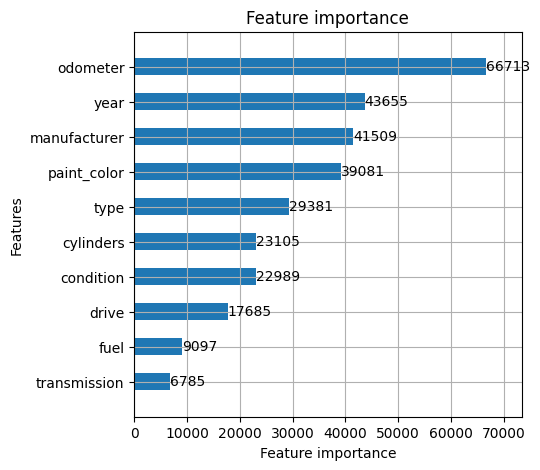

In [105]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

6.10 GradientBoostingRegressor z użyciem HyperOpt<a class="anchor" id="5.10"></a>

In [106]:
def hyperopt_gb_score(params):
    clf = GradientBoostingRegressor(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8616013836219624                                    
{'max_depth': 8, 'n_estimators': 797}                 
0.8099177521722052                                                               
{'max_depth': 3, 'n_estimators': 313}                                            
0.8547242652614742                                                               
{'max_depth': 6, 'n_estimators': 677}                                            
0.8620100803967559                                                               
{'max_depth': 8, 'n_estimators': 599}                                            
0.8219873403153768                                                               
{'max_depth': 4, 'n_estimators': 241}                                            
0.7930288028466013                                                               
{'max_depth': 2, 'n_estimators': 445}                                            
0.8574216279645984                                                    

In [107]:
params = space_eval(space_gb, best)
params

{'max_depth': 2, 'n_estimators': 445}

In [108]:
gradient_boosting = GradientBoostingRegressor(**params)
gradient_boosting.fit(train, target)
acc_model(9,gradient_boosting,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13968.28461407  8301.69201452 17916.18638795  7579.78224951
  7225.72056347]
acc(r2_score) for train = 79.76
acc(relative error) for train = 17.02
acc(rmse) for train = 388548.38
target_test = [38000 31550  5900 13500 35000]
ytest = [22498.61667254 25019.05661039  5736.56151717 17503.84393763
 30854.20372891]
acc(r2_score) for test = 79.5
acc(relative error) for test = 16.92
acc(rmse) for test = 390390.34


6.11 RidgeRegressor<a class="anchor" id="5.11"></a>

In [109]:
ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.74260172  8399.64685999 17733.15673909 10137.097247
  6286.78880675]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.19
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.45202939 27352.66613376  4434.95517174 19549.19011371
 24916.23870525]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555793.6


6.12 BaggingRegressor<a class="anchor" id="5.12"></a>

In [110]:
bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13337.53333333  8834.63256962 16178.2         5980.3
  5653.9       ]
acc(r2_score) for train = 96.77
acc(relative error) for train = 5.44
acc(rmse) for train = 155175.43
target_test = [38000 31550  5900 13500 35000]
ytest = [34532.3        30074.7         7231.16666667 15969.4
 32128.30833333]
acc(r2_score) for test = 84.8
acc(relative error) for test = 12.7
acc(rmse) for test = 336132.11


6.13 ExtraTreesRegressor<a class="anchor" id="5.13"></a>

In [111]:
etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(12,etr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11944.    8869.75 15996.25  5600.    5490.  ]
acc(r2_score) for train = 99.31
acc(relative error) for train = 0.96
acc(rmse) for train = 71730.5
target_test = [38000 31550  5900 13500 35000]
ytest = [38000.         27275.08        7131.66666667 16339.45
 30266.095     ]
acc(r2_score) for test = 85.48
acc(relative error) for test = 11.48
acc(rmse) for test = 328496.21


6.14 AdaBoost Regressor<a class="anchor" id="5.14"></a>

In [112]:
Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15864.0021751  11594.55951662 19358.87540984 12534.42338928
 11489.21082411]
acc(r2_score) for train = 61.97
acc(relative error) for train = 25.78
acc(rmse) for train = 532585.58
target_test = [38000 31550  5900 13500 35000]
ytest = [21940.83993247 23085.21127072  9959.13906465 20079.89192672
 27653.09375   ]
acc(r2_score) for test = 62.08
acc(relative error) for test = 25.49
acc(rmse) for test = 530929.89


6.15 VotingRegressor<a class="anchor" id="5.15"></a>

In [113]:
Voting_Reg = VotingRegressor(estimators=[('lin', linreg), ('ridge', ridge), ('sgd', sgd)])
Voting_Reg.fit(train, target)
acc_model(14,Voting_Reg,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17238.22607783  8373.83293136 17409.58561957 10173.78073105
  6251.11658076]
acc(r2_score) for train = 61.56
acc(relative error) for train = 24.06
acc(rmse) for train = 535407.37
target_test = [38000 31550  5900 13500 35000]
ytest = [20055.55120633 27610.7916981   4261.3542753  19590.99305078
 25044.64530435]
acc(r2_score) for test = 59.51
acc(relative error) for test = 23.98
acc(rmse) for test = 548572.16


### 7. Porównanie modeli <a class="anchor" id="6"></a>

[Spis treści](#0)

In [114]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
              'MLPRegressor', 'Stochastic Gradient Decent', 
              'Decision Tree Regressor', 'Random Forest',  'XGB', 'LGBM',
              'GradientBoostingRegressor', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', 'VotingRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [115]:
pd.options.display.float_format = '{:,.2f}'.format

In [116]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


Model  r2_train  r2_test  d_train  d_test  \
6                Random Forest     97.53    86.10     4.96   12.08   
8                         LGBM     89.87    85.77    11.48   13.41   
12         ExtraTreesRegressor     99.31    85.48     0.96   11.48   
11            BaggingRegressor     96.77    84.80     5.44   12.70   
7                          XGB     87.72    84.74    12.92   14.12   
9    GradientBoostingRegressor     79.76    79.50    17.02   16.92   
5      Decision Tree Regressor     99.31    76.63     0.96   14.42   
3                 MLPRegressor     74.07    73.97    19.27   19.08   
13           AdaBoostRegressor     61.97    62.08    25.78   25.49   
14             VotingRegressor     61.56    59.51    24.06   23.98   
0            Linear Regression     61.64    58.44    23.91   23.89   
10              RidgeRegressor     61.64    58.44    23.91   23.89   
4   Stochastic Gradient Decent     59.49    43.25    23.39   23.59   
2                   Linear SVR     44.00    35.64    27.60   27.68   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
6   135,737.11 321,455.00  
8   274,875.83 325,263.74  
12   71,730.50 328,496.21  
11  155,175.43 336,132.11  
7   302,631.95 336,763.85  
9   388,548.38 390,390.34  
5    71,730.45 416,763.88  
3   439,769.48 439,853.13  
13  532,585.58 530,929.89  
14  535,407.37 548,572.16  
0   534,865.15 555,802.12  
10  534,865.19 555,793.60  
4   549,625.25 649,482.95  
2   646,252.26 691,665.02  
1   796,758.93 796,920.98

In [117]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


Model  r2_train  r2_test  d_train  d_test  \
12         ExtraTreesRegressor     99.31    85.48     0.96   11.48   
6                Random Forest     97.53    86.10     4.96   12.08   
11            BaggingRegressor     96.77    84.80     5.44   12.70   
8                         LGBM     89.87    85.77    11.48   13.41   
7                          XGB     87.72    84.74    12.92   14.12   
5      Decision Tree Regressor     99.31    76.63     0.96   14.42   
9    GradientBoostingRegressor     79.76    79.50    17.02   16.92   
3                 MLPRegressor     74.07    73.97    19.27   19.08   
4   Stochastic Gradient Decent     59.49    43.25    23.39   23.59   
0            Linear Regression     61.64    58.44    23.91   23.89   
10              RidgeRegressor     61.64    58.44    23.91   23.89   
14             VotingRegressor     61.56    59.51    24.06   23.98   
13           AdaBoostRegressor     61.97    62.08    25.78   25.49   
2                   Linear SVR     44.00    35.64    27.60   27.68   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
12   71,730.50 328,496.21  
6   135,737.11 321,455.00  
11  155,175.43 336,132.11  
8   274,875.83 325,263.74  
7   302,631.95 336,763.85  
5    71,730.45 416,763.88  
9   388,548.38 390,390.34  
3   439,769.48 439,853.13  
4   549,625.25 649,482.95  
0   534,865.15 555,802.12  
10  534,865.19 555,793.60  
14  535,407.37 548,572.16  
13  532,585.58 530,929.89  
2   646,252.26 691,665.02  
1   796,758.93 796,920.98

In [118]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


Model  r2_train  r2_test  d_train  d_test  \
6                Random Forest     97.53    86.10     4.96   12.08   
8                         LGBM     89.87    85.77    11.48   13.41   
12         ExtraTreesRegressor     99.31    85.48     0.96   11.48   
11            BaggingRegressor     96.77    84.80     5.44   12.70   
7                          XGB     87.72    84.74    12.92   14.12   
9    GradientBoostingRegressor     79.76    79.50    17.02   16.92   
5      Decision Tree Regressor     99.31    76.63     0.96   14.42   
3                 MLPRegressor     74.07    73.97    19.27   19.08   
13           AdaBoostRegressor     61.97    62.08    25.78   25.49   
14             VotingRegressor     61.56    59.51    24.06   23.98   
10              RidgeRegressor     61.64    58.44    23.91   23.89   
0            Linear Regression     61.64    58.44    23.91   23.89   
4   Stochastic Gradient Decent     59.49    43.25    23.39   23.59   
2                   Linear SVR     44.00    35.64    27.60   27.68   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
6   135,737.11 321,455.00  
8   274,875.83 325,263.74  
12   71,730.50 328,496.21  
11  155,175.43 336,132.11  
7   302,631.95 336,763.85  
9   388,548.38 390,390.34  
5    71,730.45 416,763.88  
3   439,769.48 439,853.13  
13  532,585.58 530,929.89  
14  535,407.37 548,572.16  
10  534,865.19 555,793.60  
0   534,865.15 555,802.12  
4   549,625.25 649,482.95  
2   646,252.26 691,665.02  
1   796,758.93 796,920.98

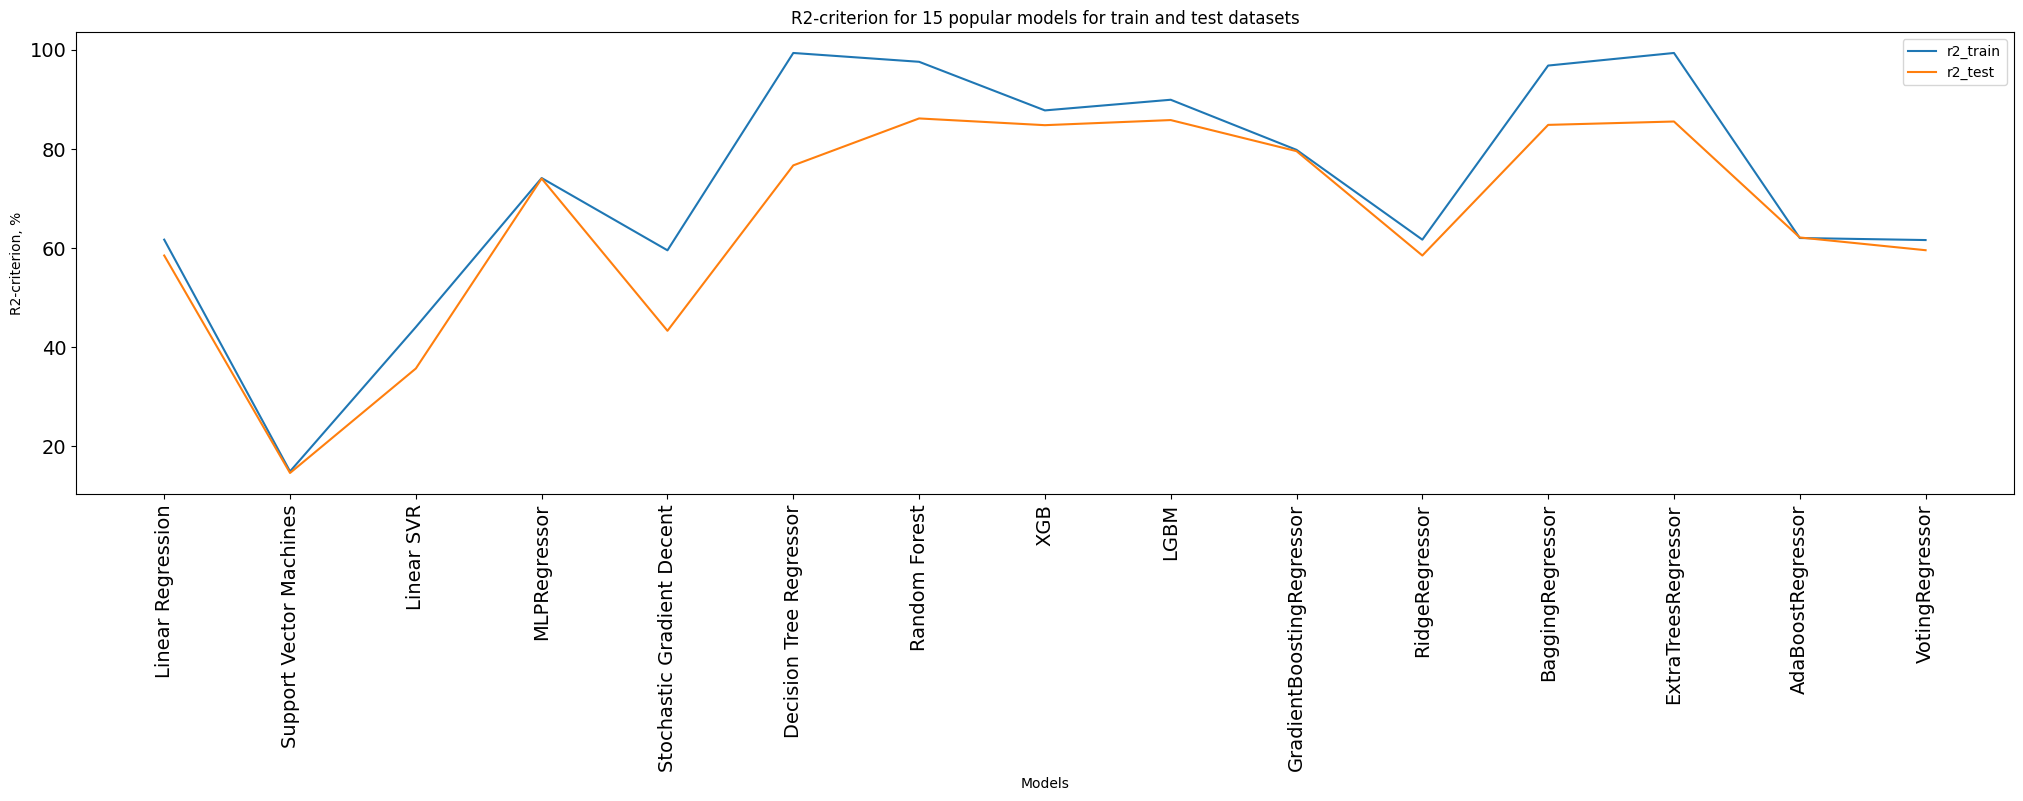

In [119]:
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

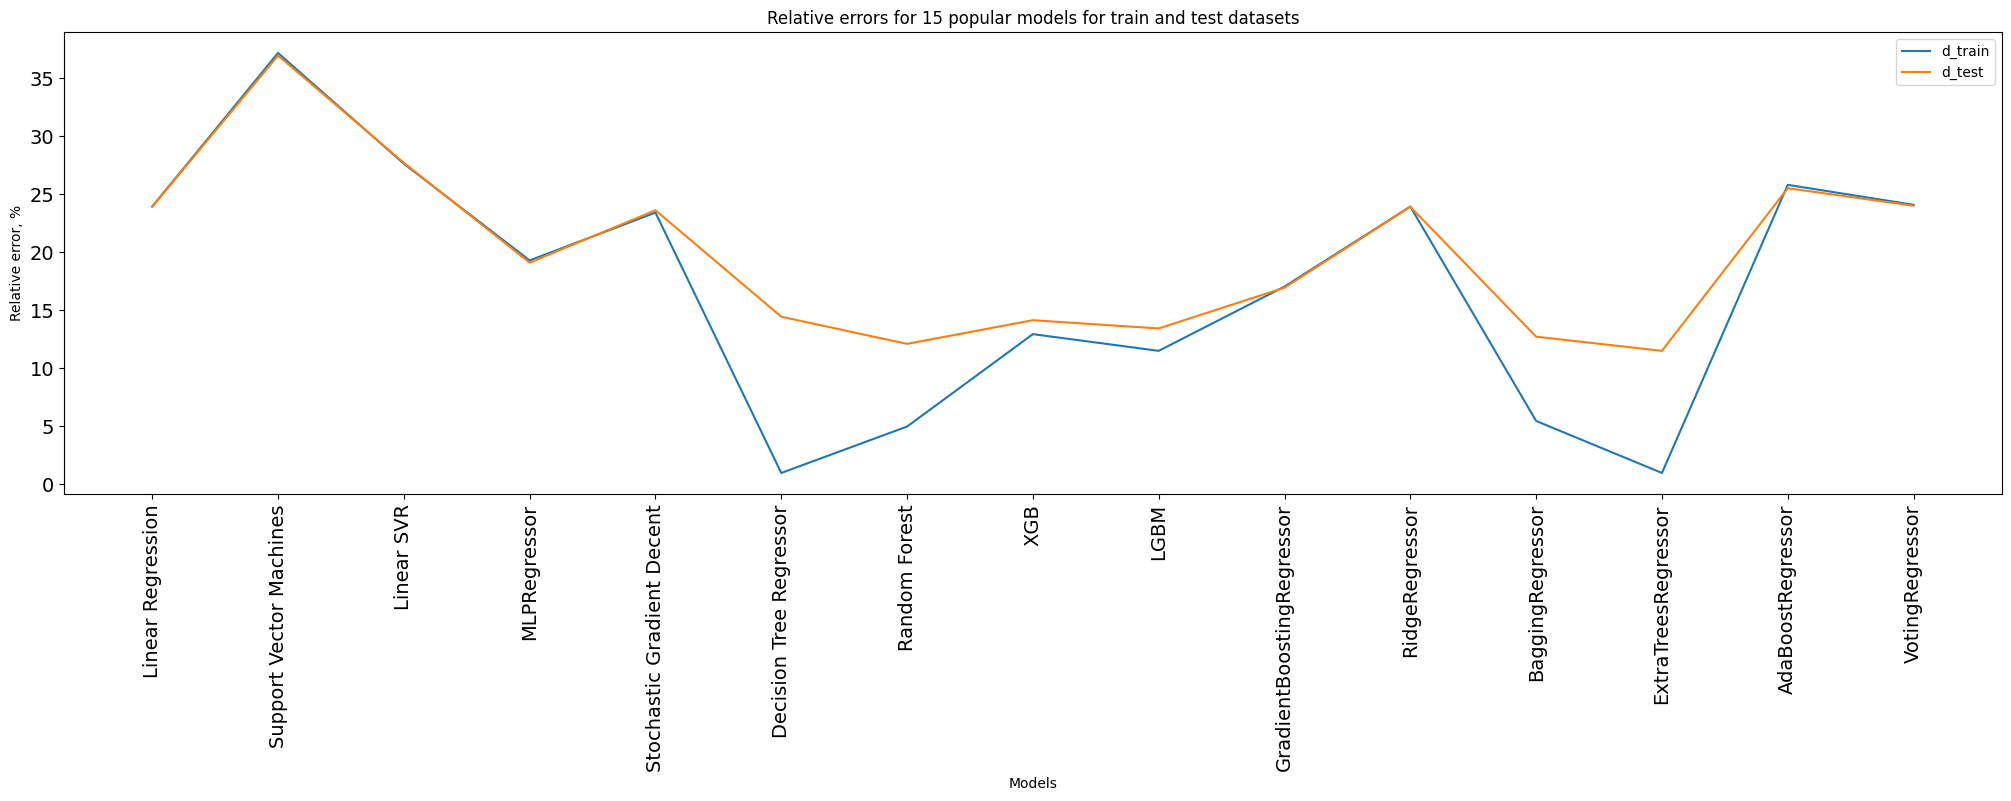

In [120]:
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

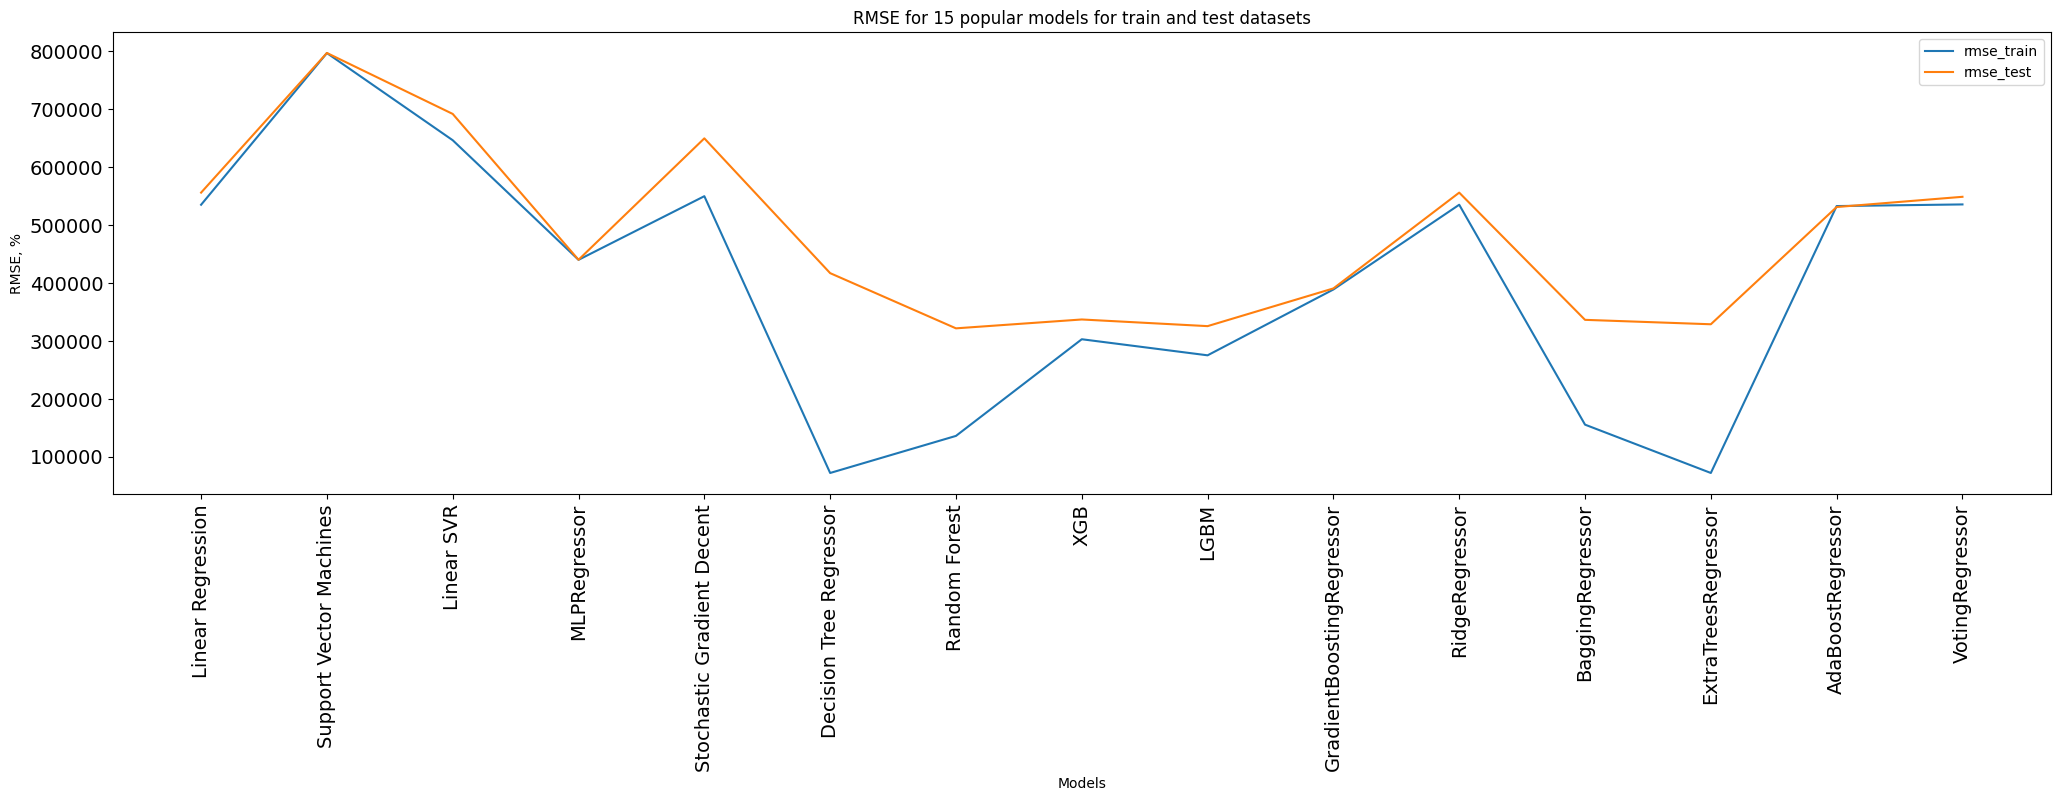

In [121]:
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

## 8. Przewidywania <a class="anchor" id="7"></a>

[Spis treści](#0)

In [122]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12300 entries, 4125 to 4066
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          12300 non-null  int32
 1   manufacturer  12300 non-null  int32
 2   condition     12300 non-null  int32
 3   cylinders     12300 non-null  int32
 4   fuel          12300 non-null  int32
 5   odometer      12300 non-null  int32
 6   transmission  12300 non-null  int32
 7   drive         12300 non-null  int32
 8   type          12300 non-null  int32
 9   paint_color   12300 non-null  int32
dtypes: int32(10)
memory usage: 576.6 KB


In [123]:
test0.head(3)

year  manufacturer  condition  cylinders  fuel  odometer  \
4125     113            13          2          6     0        39   
484128   112             7          0          3     2        46   
144345   115            13          3          5     2        17   

        transmission  drive  type  paint_color  
4125               0      0    10           10  
484128             0      1     9           10  
144345             0      0    10           10

In [124]:
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [125]:
linreg.fit(train0, train_target0)
linreg.predict(testn)[:3]

array([26282.33506249,  5094.20329735, 21368.99522328])

In [126]:
ridge.fit(train0, train_target0)
ridge.predict(testn)[:3]

array([26280.85232725,  5096.58802575, 21368.59620244])